<a href="https://colab.research.google.com/github/24GUNV/aibuilders/blob/main/TensorFlow_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
!sudo apt -y install libportaudio2
!pip install scann
!pip uninstall -y protobuf && pip install -q protobuf==3.19
!pip uninstall -y folium && pip install -q folium==0.2.1
!pip uninstall -y packaging && pip install -q packaging==20.9
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.0
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (222 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
spec = model_spec.get('efficientdet_lite0')

In [ ]:
# train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('temp.csv')

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=32, train_whole_model=True, validation_data=validation_data)

Epoch 1/50
39/39 [==============================] - 68s 701ms/step - det_loss: 1.4889 - cls_loss: 1.0508 - box_loss: 0.0088 - reg_l2_loss: 0.0635 - loss: 1.5524 - learning_rate: 0.0240 - gradient_norm: 0.9304 - val_det_loss: 1.4880 - val_cls_loss: 1.0621 - val_box_loss: 0.0085 - val_reg_l2_loss: 0.0635 - val_loss: 1.5515
Epoch 2/50
39/39 [==============================] - 26s 663ms/step - det_loss: 0.7077 - cls_loss: 0.5594 - box_loss: 0.0030 - reg_l2_loss: 0.0636 - loss: 0.7713 - learning_rate: 0.0399 - gradient_norm: 1.4465 - val_det_loss: 1.6560 - val_cls_loss: 1.0755 - val_box_loss: 0.0116 - val_reg_l2_loss: 0.0637 - val_loss: 1.7197
Epoch 3/50
39/39 [==============================] - 25s 653ms/step - det_loss: 0.4693 - cls_loss: 0.3734 - box_loss: 0.0019 - reg_l2_loss: 0.0638 - loss: 0.5331 - learning_rate: 0.0397 - gradient_norm: 1.6327 - val_det_loss: 1.5532 - val_cls_loss: 1.0218 - val_box_loss: 0.0106 - val_reg_l2_loss: 0.0639 - val_loss: 1.6171
Epoch 4/50
39/39 [=============

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 16s 2s/step



{'AP': 0.76572937,
 'AP50': 0.86301947,
 'AP75': 0.8448816,
 'AP_/cardboard': 0.8371167,
 'AP_/glass': 0.72834533,
 'AP_/metal': 0.832963,
 'AP_/paper': 0.8029594,
 'AP_/plastic': 0.6272623,
 'APl': 0.7666683,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.8609286,
 'ARm': -1.0,
 'ARmax1': 0.827739,
 'ARmax10': 0.8609286,
 'ARmax100': 0.8609286,
 'ARs': -1.0}

In [ ]:
model.export(export_dir='.')

In [ ]:
!rm -r aibuilders
!git clone https://github.com/24GUNV/aibuilders
!mkdir aibuilders/object_detection/train

rm: cannot remove 'aibuilders': No such file or directory
Cloning into 'aibuilders'...
remote: Enumerating objects: 6297, done.
remote: Counting objects: 100% (3694/3694), done.
remote: Compressing objects: 100% (2102/2102), done.
remote: Total 6297 (delta 1647), reused 3610 (delta 1568), pack-reused 2603
Receiving objects: 100% (6297/6297), 57.49 MiB | 34.37 MiB/s, done.
Resolving deltas: 100% (1682/1682), done.


In [ ]:
import glob
import shutil
import xml.etree.cElementTree as ET
import pandas as pd
import random

In [ ]:
valid_folders = glob.glob('aibuilders/object_detection/images/*')
valid_fnames = []
for folder in valid_folders:
  for file in glob.glob(f'{folder}/*'):
      shutil.copyfile(
          file,
          f'aibuilders/object_detection/train/{file.split("/")[-1]}'
        )
      valid_fnames.append(file)
random.shuffle(valid_fnames)

df = pd.DataFrame(columns=["type", "filename", "name", "left", "top", "right", "top", "right", "bottom", "left", "bottom"])

# Looping through all of the files
for i, file in enumerate(valid_fnames):
  # Checks if it is an xml file or not
  try:
    # Parse into the lists
    tree = ET.parse(file)
    root = tree.getroot()
    filename = ''.join(list(file.split(".")[:-1]) + [".jpg"])
    name = root[6][0].text
    width = int(root[4][0].text)
    height = int(root[4][1].text)
    left = int(root[6][4][0].text) / width
    top = int(root[6][4][1].text) / height
    right = int(root[6][4][2].text) / width
    bottom = int(root[6][4][3].text) / height

    if i < 0.8 * len(valid_fnames):
      df.loc[i]=["TRAINING", filename, name, left, top, right, top, right, bottom, left, bottom]
    elif i < 0.9* len(valid_fnames):
      df.loc[i]=["VALIDATION", filename, name, left, top, right, top, right, bottom, left, bottom]
    else:
      df.loc[i]=["TEST",filename, name, left, top, right, top, right, bottom, left, bottom]
  except:
    continue

In [ ]:
df

,type,filename,name,left,top,right,top,right,bottom,left,bottom
11,TRAINING,aibuilders/object_detection/images/cardboard/c...,cardboard,0.001953,0.002604,1.000000,0.002604,1.000000,1.000000,0.001953,1.000000
14,TRAINING,aibuilders/object_detection/images/plastic/pla...,plastic,0.001953,0.002604,1.000000,0.002604,1.000000,0.869792,0.001953,0.869792
24,TRAINING,aibuilders/object_detection/images/metal/metal...,metal,0.088889,0.044444,1.000000,0.044444,1.000000,0.906667,0.088889,0.906667
25,TRAINING,aibuilders/object_detection/images/glass/white...,glass,0.125000,0.088542,1.000000,0.088542,1.000000,1.000000,0.125000,1.000000
27,TRAINING,aibuilders/object_detection/images/plastic/pla...,plastic,0.205078,0.106771,0.833984,0.106771,0.833984,1.000000,0.205078,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
5628,TEST,aibuilders/object_detection/images/cardboard/c...,cardboard,0.001953,0.002604,1.000000,0.002604,1.000000,1.000000,0.001953,1.000000
5629,TEST,aibuilders/object_detection/images/glass/white...,glass,0.240000,0.008889,0.755556,0.008889,0.755556,0.973333,0.240000,0.973333
5631,TEST,aibuilders/object_detection/images/glass/green...,glass,0.210938,0.218750,0.671875,0.218750,0.671875,0.695312,0.210938,0.695312
5639,TEST,aibuilders/object_detection/images/metal/metal...,metal,0.195312,0.247396,0.806641,0.247396,0.806641,0.742188,0.195312,0.742188


In [ ]:
df.to_csv('test.csv', index=False)

In [ ]:
with open("test.csv",'r') as f, open("temp.csv",'w') as f1:
    next(f) # skip header line
    for line in f:
        f1.write(line)

In [ ]:
import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = {
    0: "cardboard",
    1: "plastic",
    2: "metal",
    3: "glass",
    4: "paper"
}
# label_map = model.model_spec.config.label_map
# for label_id, label_name in label_map.as_dict().items():
#   classes[label_id-1] = label_name
# print(model.model_spec.config.num_classes)
# print(model.model_spec.config)
# print(classes)

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(5, 3), dtype=np.uint8)

def preprocess_image(image, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.convert_to_tensor(image, dtype=tf.float32)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

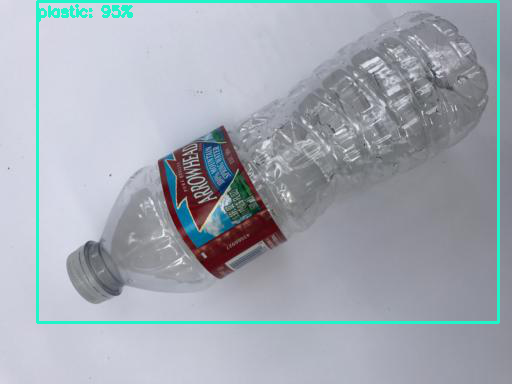

In [ ]:
import PIL
INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg"
DETECTION_THRESHOLD = 0.3

TEMP_FILE = 'aibuilders/object_detection/images/plastic/plastic10.jpg'
arr = np.array(PIL.Image.open(TEMP_FILE))
# !wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
# im = Image.open(TEMP_FILE)
# im.thumbnail((512, 512), Image.ANTIALIAS)
# im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    arr,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(  detection_result_image)